In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC


## Import profile data into a dataframe

df = pd.read_csv("profiles.csv")


## Select pertinent columns

df1 = df.loc[:,['smokes','drinks','drugs']]


## Drop any row with NaN

df1.dropna(axis=0, how='any', inplace=True)


## Map responses to discrete codes

smokes_mapping = {"no": 0, "sometimes": 1, "when drinking": 2, "yes": 3, "trying to quit": 4}
drinks_mapping = {"socially": 0, "rarely": 1, "often": 2, "not at all": 3, "very often": 4, "desperately": 5}
drugs_mapping = {"never": 0, "sometimes": 1, "often": 2}

df1["smokes_code"] = df1.smokes.map(smokes_mapping)
df1["drinks_code"] = df1.drinks.map(drinks_mapping)
df1["drugs_code"] = df1.drugs.map(drugs_mapping)


## Create the data list and corresponding label list

df_list = df1[['smokes_code','drinks_code']]

df_labels = df1['drugs_code']


## Divide data into training and validation sets

(training_data, validation_data, training_labels, validation_labels) = train_test_split(df_list, df_labels, test_size = 0.2, random_state = 100)


## Find the optimal number of k = nearest neighbors

accuracies = []
for k in range(1, 21):
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(training_data, training_labels)
  accuracies.append(classifier.score(validation_data, validation_labels))


## Plot accuracy against k-value

k_list = range(1, 21)
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Classifier Accuracy")
plt.show()


## Implement KNN classifier with k = 8

classifier_KNN = KNeighborsClassifier(n_neighbors = 8)
classifier_KNN.fit(training_data, training_labels)
print("KNN classifier accuracy using score function:", classifier_KNN.score(validation_data, validation_labels))

guesses = classifier_KNN.predict(validation_data)
print("KNN classifier accuracy using predict & accuracy_score functions:", accuracy_score(validation_labels, guesses))


## Implement SVM

classifier_SVM = SVC(kernel = 'linear', C = 0.5)
classifier_SVM.fit(training_data, training_labels)
print("SVM classifier accuracy using score function:", classifier_SVM.score(validation_data, validation_labels))

guesses2 = classifier_SVM.predict(validation_data)
print("SVM classifier accuracy using predict & accuracy_score functions:", accuracy_score(validation_labels, guesses2))


<Figure size 640x480 with 1 Axes>

KNN classifier accuracy using score function: 0.8257442052006119
KNN classifier accuracy using predict & accuracy_score functions: 0.8257442052006119
SVM classifier accuracy using score function: 0.817154959406989
SVM classifier accuracy using predict & accuracy_score functions: 0.817154959406989


Text(0.5, 0, 'Drugs code')

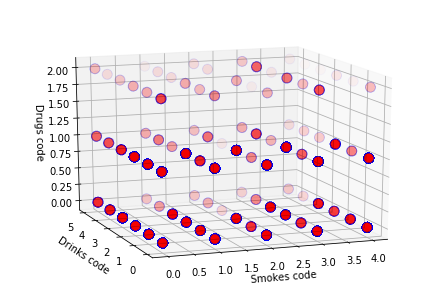

In [2]:
## Plot drug use as a function of smoking and drinking

fig = plt.figure(1, figsize=(6, 4))
plt.clf()

elev = 15.0
azim = -110

ax = Axes3D(fig, elev=elev, azim=azim)

ax.scatter(df1[['smokes_code']], df1[['drinks_code']], df1[['drugs_code']], c='r', marker='o', s=100, edgecolor ='blue', alpha=0.02)

ax.set_xlabel('Smokes code')
ax.set_ylabel('Drinks code')
ax.set_zlabel('Drugs code')


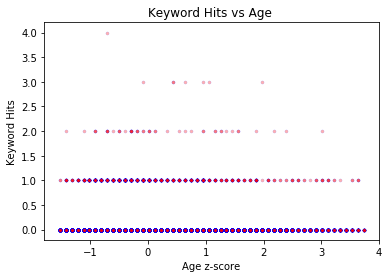

In [3]:
## Download the "age" and essay columns into a dataframe

ae = df.loc[:,["age","essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]]


## Eliminate any row with NaN

ae.dropna(axis=0, how='any', inplace=True)


## Calculate the number of times each person uses a casual dating keyword

word_hits = []
age_axis = []

for idx in ae.age.index:
    combined_essay = ae.essay0[idx] + ae.essay1[idx] + ae.essay2[idx] + ae.essay3[idx] + ae.essay4[idx] + ae.essay5[idx] + ae.essay6[idx] + ae.essay7[idx] + ae.essay8[idx] + ae.essay9[idx]
    essay_split = combined_essay.split()
    
    #search_string = ["marriage", "committed", "serious"]
    search_string = ["casual", "fling", "NSA"]
     
    tally = 0
    
    for item in search_string:
        tally += essay_split.count(item)
    
    word_hits.append(tally)
    age_axis.append(ae.age[idx])
    
ae["word_hits"] = word_hits
ae["age_axis"] = age_axis


## Z-score normalization (use of word hits z-score isn't necessary)

ae["wh_zscore"] = (ae.word_hits - ae.word_hits.mean())/ae.word_hits.std(ddof=0)
ae["age_zscore"] = (ae.age_axis - ae.age_axis.mean())/ae.age_axis.std(ddof=0)


## Plot results

plt.scatter(ae.age_zscore, ae.word_hits, s=10, c='red', alpha=0.3, linewidths=0.3, edgecolors='blue')

plt.xlabel("Age z-score")
plt.ylabel("Keyword Hits")
plt.title("Keyword Hits vs Age ")
plt.show()


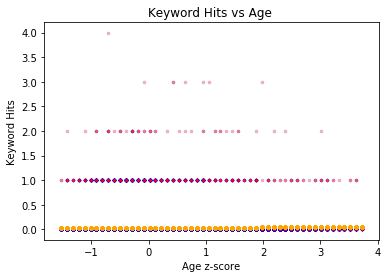

Linear regression R^2 score: 0.0007425622040293511


In [4]:
## Implement linear regression

word_ax = np.array(ae.word_hits)
word_ax = word_ax.reshape(-1, 1)
age_ax = np.array(ae.age_zscore)
age_ax = age_ax.reshape(-1, 1)

line_fitter = LinearRegression()

line_fitter.fit(age_ax, word_ax)

predict = line_fitter.predict(age_ax)

plt.scatter(age_ax, word_ax, s=10, c='red', alpha=0.3, linewidths=0.3, edgecolors='blue')
plt.scatter(age_ax, predict, s=10, c='orange')
plt.xlabel("Age z-score")
plt.ylabel("Keyword Hits")
plt.title("Keyword Hits vs Age ")
plt.show()

print("Linear regression R^2 score:", r2_score(word_ax, predict, sample_weight=None, multioutput='uniform_average'))

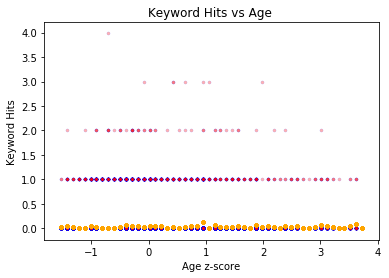

KNN regression R^2 score: -0.007122827754977745


In [5]:
## Implement KNN regression

regressor = KNeighborsRegressor(n_neighbors = 100, weights = "distance")

regressor.fit(age_ax, word_ax)

predict2 = regressor.predict(age_ax)

plt.scatter(age_ax, word_ax, s=10, c='red', alpha=0.3, linewidths=0.3, edgecolors='blue')
plt.scatter(age_ax, predict2, s=10, c='orange')
plt.xlabel("Age z-score")
plt.ylabel("Keyword Hits")
plt.title("Keyword Hits vs Age ")
plt.show()

print("KNN regression R^2 score:", r2_score(word_ax, predict2, sample_weight=None, multioutput='uniform_average'))

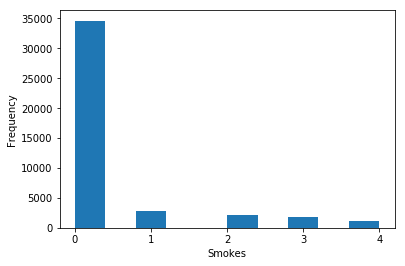

In [6]:
## Exploration of the dataset: smoking

plt.hist(df1.smokes_code)
plt.xlabel("Smokes")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 5, 1))
plt.show()

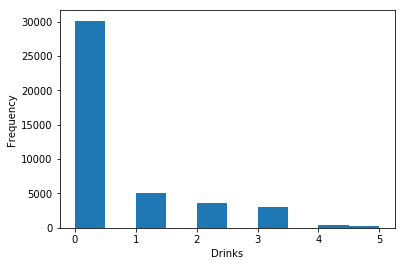

In [7]:
## Exploration of the dataset: drinking

plt.hist(df1.drinks_code)
plt.xlabel("Drinks")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 6, 1))
plt.show()